# Bynary Classification

## Library & Dataset Import

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
import os
import json
import joblib
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from utils.w2v_feature_extraction import compute_w2v_features

df_train = pd.read_csv("../dataset/training_set.csv")
df_train.head()
X_text = df_train["text"]
y_binary = df_train["binary_label"]

## Dataset balancing and Feature Extraction

In [4]:
import pandas as pd
import numpy as np
import random
import nlpaug.augmenter.word as naw
from sklearn.utils import shuffle

# --- Seed per riproducibilità ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# --- Carica il dataset originale ---
df_train = pd.read_csv("../dataset/training_set.csv")  # Modifica path se necessario

# --- Separa classi maggioritaria e minoritaria ---
df_minority = df_train[df_train["binary_label"] == "not_cyberbullying"]
df_majority = df_train[df_train["binary_label"] == "cyberbullying"]

print("Distribuzione originale:")
print(df_train["binary_label"].value_counts())

# --- Augmenter veloce con WordNet ---
aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)

# --- Quanti esempi generare per bilanciare ---
n_to_generate = len(df_majority) - len(df_minority)
minority_texts = df_minority["text"].tolist()

# --- Genera frasi aumentate in modo rapido ---
augmented_texts = []
i = 0
while len(augmented_texts) < n_to_generate:
    text = minority_texts[i % len(minority_texts)]
    try:
        aug_text = aug.augment(text)
        augmented_texts.append(aug_text)
    except Exception:
        pass
    i += 1

# --- Costruisci DataFrame aumentato ---
df_augmented = pd.DataFrame({
    "text": augmented_texts,
    "binary_label": "not_cyberbullying"
})

# --- Combina tutto e mischia ---
df_balanced = pd.concat([df_train, df_augmented], ignore_index=True)
df_balanced = shuffle(df_balanced, random_state=SEED).reset_index(drop=True)

print("\nDistribuzione dopo il bilanciamento:")
print(df_balanced["binary_label"].value_counts())

# --- Output finale per addestramento ---
X_text = df_balanced["text"].fillna("").astype(str)
y_binary = df_balanced["binary_label"].map({
    "cyberbullying": 1,
    "not_cyberbullying": 0
})



Distribuzione originale:
binary_label
cyberbullying        31594
not_cyberbullying     6243
Name: count, dtype: int64

Distribuzione dopo il bilanciamento:
binary_label
cyberbullying        31594
not_cyberbullying    31594
Name: count, dtype: int64


In [5]:
# BoW
bow_vectorizer = CountVectorizer(max_features=350)
X_bow = bow_vectorizer.fit_transform(X_text)
joblib.dump(bow_vectorizer, "../model/bow_vocabulary.pkl")

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=350)
X_tfidf = tfidf_vectorizer.fit_transform(X_text)
joblib.dump(bow_vectorizer, "../model/tfidf_vocabulary.pkl")

# Load Word2Vec models
model1 = Word2Vec.load("../model/word2vec_model1.model")
model2 = Word2Vec.load("../model/word2vec_model2.model")

X_w2v1 = compute_w2v_features(X_text, model1, model1.vector_size)
X_w2v2 = compute_w2v_features(X_text, model2, model2.vector_size)


## GRID search

In [7]:
os.makedirs("../model", exist_ok=True)
results_list = []

# Hyperparameter Grid
param_grid = {
    "LogisticRegression": {
        "model__C": [0.01, 1, 10],
        "model__class_weight": ["balanced"]
    },
    "LinearSVM": {
        "model__C": [0.01, 0.1, 1, 10]
    },
    "RandomForest": {
        "model__n_estimators": [100, 200, 500, 1000],
        "model__max_depth": [None, 10, 20],
        "model__class_weight": ["balanced"],
        "model__random_state": [42]
    }
}

# Selected model
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "LinearSVM": LinearSVC(max_iter=10000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier()
}

# Vectorization method
datasets = {
    "BoW": X_bow,
    "TF-IDF": X_tfidf,
    "W2V-1": X_w2v1,
    "W2V-2": X_w2v2
}

# Evaluation Metrics
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

for vectorizer_name, X in datasets.items():
    for model_name, model in models.items():

        # Pipeline: Word2Vec only
        steps = []
        if "W2V" in vectorizer_name:
            steps.append(("scaler", StandardScaler()))
        steps.append(("model", model))
        pipeline = Pipeline(steps)

        # Grid Search
        grid = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid[model_name],
            cv=cv_strategy,
            scoring=scoring,
            refit="f1", 
            n_jobs=-1,
            verbose=1
        )

        grid.fit(X, y_binary)

        
        model_path = f"../model/grid_search_binary_f1/{model_name}_{vectorizer_name}.pkl"
        joblib.dump(grid.best_estimator_, model_path)

        best_idx = grid.best_index_
        results_list.append({
            "model": model_name,
            "vectorizer": vectorizer_name,
            "accuracy": grid.cv_results_["mean_test_accuracy"][best_idx],
            "precision": grid.cv_results_["mean_test_precision"][best_idx],
            "recall": grid.cv_results_["mean_test_recall"][best_idx],
            "f1": grid.cv_results_["mean_test_f1"][best_idx]
        })

with open("../model/grid_search_binary_f1/results_grid_search_model.json", "w") as f:
    json.dump(results_list, f, indent=2)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


## K-fold Cross Validation and Model Evaluation

In [8]:
# Dataset
datasets = {
    "BoW": X_bow,
    "TF-IDF": X_tfidf,
    "W2V-1": X_w2v1,
    "W2V-2": X_w2v2
}
y = y_binary

# Cross-validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Scoring con gestione zero_division
scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1": make_scorer(f1_score, zero_division=0)
}

# Path ai modelli
model_dir = "../model/grid_search_binary_f1"
#model_dir = "../model/grid_search_binary_recall"
eval_results = []

for fname in os.listdir(model_dir):
    if fname.endswith(".pkl") and "_" in fname:
        model_name, vectorizer_name = fname.replace(".pkl", "").split("_", 1)
        model_path = os.path.join(model_dir, fname)
        model = joblib.load(model_path)

        if vectorizer_name not in datasets:
            print(f"Dataset '{vectorizer_name}' not found.")
            continue

        X = datasets[vectorizer_name]

        try:
            scores = cross_validate(
                model,
                X,
                y,
                cv=cv,
                scoring=scoring,
                n_jobs=-1
            )
        except Exception as e:
            print(f"Error evaluating {model_name} with {vectorizer_name}: {e}")
            scores = {}

        # Calcolo delle metriche con nan-safe mean
        result = {
            "model": model_name,
            "vectorizer": vectorizer_name
        }

        for key in ["accuracy", "precision", "recall", "f1"]:
            score_values = scores.get(f"test_{key}", [np.nan])
            mean_score = np.nanmean(score_values)
            result[key] = mean_score

            if np.isnan(mean_score):
                print(f"{model_name} + {vectorizer_name}: '{key}' is NaN")

        eval_results.append(result)

df_eval = pd.DataFrame(eval_results)
df_eval_sorted = df_eval.sort_values(by="f1", ascending=False)
#df_eval_sorted = df_eval.sort_values(by="recall", ascending=False)

display(df_eval_sorted)



,model,vectorizer,accuracy,precision,recall,f1
3,RandomForest,BoW,0.890818,0.961483,0.814269,0.881763
2,RandomForest,TF-IDF,0.887668,0.959010,0.809964,0.878200
10,RandomForest,W2V-2,0.859862,0.898904,0.810945,0.852657
11,RandomForest,W2V-1,0.858454,0.899974,0.806577,0.850712
1,LogisticRegression,BoW,0.849718,0.908342,0.777964,0.838104
0,LinearSVM,BoW,0.850051,0.919089,0.767709,0.836597
9,LogisticRegression,TF-IDF,0.841900,0.880318,0.791448,0.833505
6,LinearSVM,TF-IDF,0.842344,0.888520,0.782997,0.832407
4,LogisticRegression,W2V-2,0.789738,0.792274,0.785466,0.788843
7,LinearSVM,W2V-2,0.789074,0.793020,0.782395,0.787661



--- RandomForest + BoW ---
Accuracy:  0.7995771670190275
Precision: 0.9383671681028187
Recall:    0.813394100519053
F1 Score:  0.8714227587142276


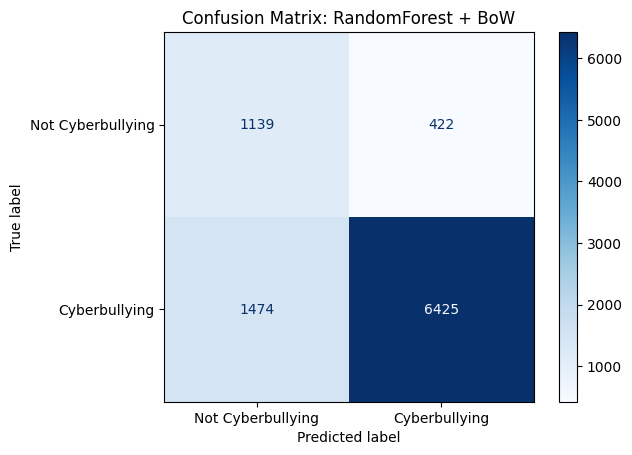


--- RandomForest + TF-IDF ---
Accuracy:  0.7772727272727272
Precision: 0.9489922480620155
Recall:    0.7749082162299025
F1 Score:  0.8531604989894767


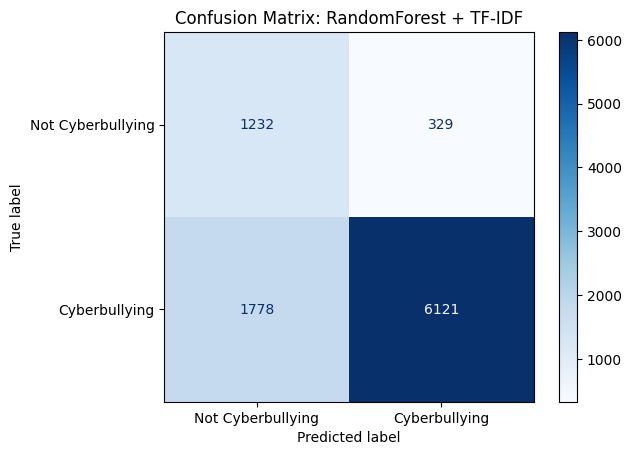

In [9]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from statsmodels.stats.contingency_tables import mcnemar
import gensim
from utils.w2v_feature_extraction import compute_w2v_features
from sklearn.feature_extraction.text import TfidfVectorizer

# --- 1. Carica il test set ---
df_test = pd.read_csv("../dataset/test_set.csv")
X_test_text = df_test["text"]
y_test = df_test["binary_label"].map({"cyberbullying": 1, "not_cyberbullying": 0}).values

# --- 2. carica i vocabolari e feature extraction ---

tfidf_vectorizer = joblib.load("../model/tfidf_vocabulary.pkl")
bow_vectorizer = joblib.load("../model/tfidf_vocabulary.pkl")

# --- Carica i due modelli Word2Vec ---
w2v_model_1 = gensim.models.Word2Vec.load("../model/word2vec_model1.model")  
w2v_model_2 = gensim.models.Word2Vec.load("../model/word2vec_model1.model")

# --- feature extractiont ---
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)
X_test_bow = bow_vectorizer.transform(X_test_text)
X_test_w2v_1 = compute_w2v_features(X_test_text, w2v_model_1, w2v_model_1.vector_size)
X_test_w2v_2 = compute_w2v_features(X_test_text, w2v_model_2, w2v_model_2.vector_size)


# Mappe dei dataset test (già calcolati)
datasets = {
    "BoW": X_test_bow,
    "TF-IDF": X_test_tfidf,
    "W2V-1": X_test_w2v_1,
    "W2V-2": X_test_w2v_2
}

# Prendi i primi 3 modelli dal DataFrame ordinato
top_models = df_eval_sorted.head(2)

# Funzione per stampare metriche
def print_metrics_and_confmat(y_true, y_pred, title):
    print(f"\n--- {title} ---")
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:   ", recall_score(y_true, y_pred))
    print("F1 Score: ", f1_score(y_true, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Cyberbullying", "Cyberbullying"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {title}")
    plt.show()

# Ciclo per caricare e valutare i top 3 modelli
for _, row in top_models.iterrows():
    model_name = row["model"]
    vectorizer_name = row["vectorizer"]
    
    # Path del modello
    file_name = f"../model/grid_search_binary_f1/{model_name}_{vectorizer_name}.pkl"
    
    # Carica modello
    clf = joblib.load(file_name)
    
    # Dataset corrispondente
    X_input = datasets[vectorizer_name]
    
    # Predizione
    y_pred = clf.predict(X_input)
    
    # Stampa metriche e confusion matrix
    print_metrics_and_confmat(y_test, y_pred, f"{model_name} + {vectorizer_name}")